In [28]:
# http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/

# http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera16itsc.pdf
# pdf contains description of data (what each column means)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import os

import folium
from geopy.distance import distance
from datetime import datetime, UTC

from ride_parser import UAHRideParser, RealRideParser
from app_data_parser import  generate_acc_from_vel
from PIL import Image

import matplotlib.dates as mdates

In [29]:
def display_velocity_graph(vel_df):
    #  https://stackoverflow.com/questions/75566545/problem-with-matplotlib-date-formatting-and-conversion-from-epoch-time-overlowe
	plt.rcParams['date.converter'] = 'concise'

	fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')
    # common to all three:
    # for ax in axs:
	# ax[1].plot(time.astype('datetime64[s]'), y)

	# ax.plot('date', 'adj_close', data=data)
	plt.plot("timestamp", "SPEED", data=vel_df)
	# Major ticks every half year, minor ticks every second,
	# axs.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(60)))
	# axs.xaxis.set_minor_locator(mdates.MinuteLocator())
	axs.grid(True)
	axs.set_ylabel("Velocidade")
	axs.set_xlabel("Horário UTC")

	# ax = axs[0]
	first_timestamp = vel_df.iloc[0]["timestamp"]
	record_day_month_year_string = datetime.fromtimestamp(first_timestamp, UTC).strftime("%d/%m/%Y")
	axs.set_title("Captura " + record_day_month_year_string)

	# axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
	# # Rotates and right-aligns the x labels so they don't crowd each other.
	# for label in axs.get_xticklabels(which='major'):
	# 	label.set(rotation=30, horizontalalignment='right')

	plt.show()

In [30]:
def display_acc_graph(acc_df):
	fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')

	plt.plot("timestamp", "acceleration", data=acc_df)
	
	axs.grid(True)
	axs.set_ylabel("Aceleração")
	axs.set_xlabel("Horário UTC")

	first_timestamp = acc_df.iloc[0]["timestamp"]
	record_day_month_year_string = datetime.fromtimestamp(first_timestamp, UTC).strftime("%d/%m/%Y")
	axs.set_title("Captura " + record_day_month_year_string)

	plt.show()

In [31]:
ride_root_dir = os.path.join("RealData", "Data_2023-11-20_pt3")

real_ride = RealRideParser(ride_root_dir)

latitudes = real_ride.gps_df["lat"]
longitudes = real_ride.gps_df["long"]

qtty_data = len(latitudes)

lat_longs = [(latitudes.iloc[i], longitudes.iloc[i]) for i in range(qtty_data)]

real_ride.accelerometer_df.head(3)

,timestamp,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,grav_x,grav_y,grav_z,acc_resultant
0,1.700518e+09,0.00,7.62,5.99,0.00,7.62,5.99,0.00,0.00,0.00,9.692497
1,1.700518e+09,0.08,-0.28,-0.24,0.08,-0.28,-0.24,0.16,7.56,6.24,0.377359
2,1.700518e+09,-0.15,-0.46,0.24,-0.15,-0.46,0.24,0.19,7.53,6.28,0.540093


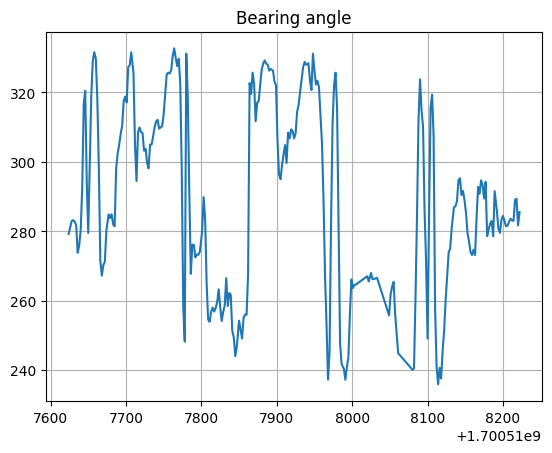

In [32]:
real_ride.generate_graph_for_bearing()

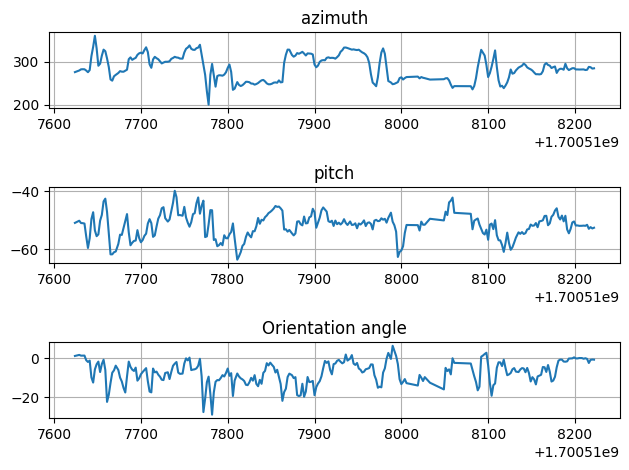

In [33]:
real_ride.generate_graph_for_orientation()

In [34]:
obd_data = real_ride.obd_data

vels_from_obd_df = obd_data["SPEED"]

# display_velocity_graph(vels_from_obd_df)

In [35]:
print(real_ride.get_acc_stats())
real_ride.gps_df
vels_from_gps_df = real_ride.create_velocity_from_gps_df()
# display_velocity_graph(vels_from_gps_df.iloc[-150:])
# vels_from_gps_df.plot(x="timestamp", y="velocity")

count    279.000000
mean       1.649987
std        1.313159
min        0.114455
25%        0.774822
50%        1.343726
75%        2.226050
max       10.569730
Name: acc_resultant, dtype: float64


In [36]:
gps_timestamps = vels_from_gps_df["timestamp"]
obd_timestamps = vels_from_obd_df["timestamp"]

min_gps_time = gps_timestamps.min()
max_gps_time = gps_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_gps_time, min_obd_time)
max_time_filter = min(max_gps_time, max_obd_time)

min_time_filter, max_time_filter

(1700517635.0, 1700517993.0)

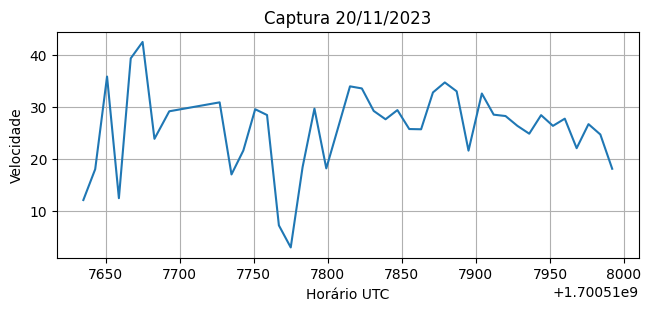

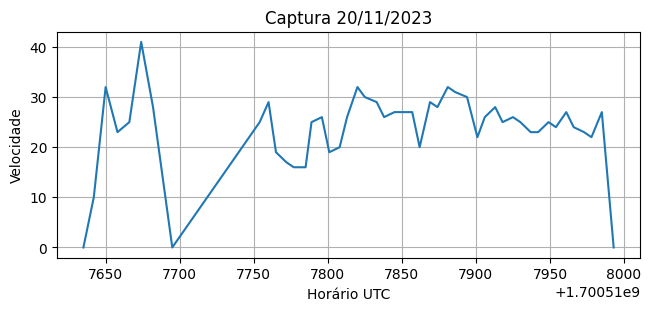

In [37]:
filter_gps = (vels_from_gps_df["timestamp"] >= min_time_filter) & (vels_from_gps_df["timestamp"] <= max_time_filter)
filtered_vels_from_gps_df = vels_from_gps_df[filter_gps]

display_velocity_graph(filtered_vels_from_gps_df)

filter_obd = (vels_from_obd_df["timestamp"] >= min_time_filter) & (vels_from_obd_df["timestamp"] <= max_time_filter)
filtered_vels_from_obd_df = vels_from_obd_df[filter_obd]

display_velocity_graph(filtered_vels_from_obd_df)

6.07407777106264

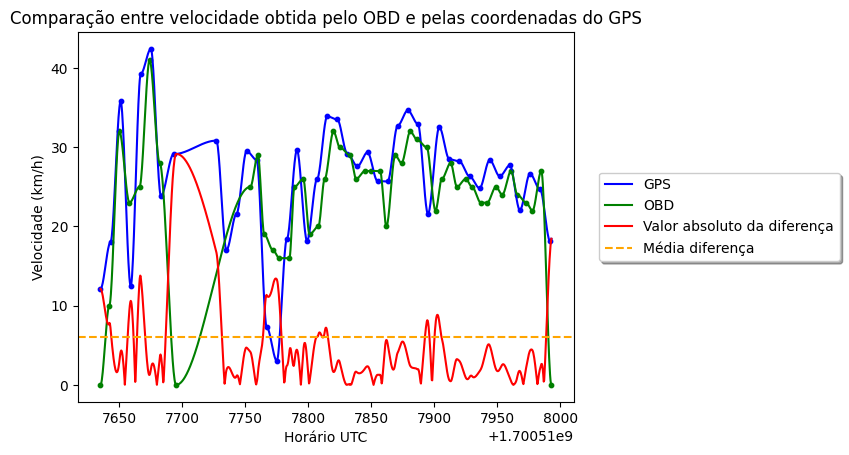

In [38]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# GPS
x_gps = filtered_vels_from_gps_df["timestamp"]
y_gps = filtered_vels_from_gps_df["SPEED"]
p_gps = CubicHermiteSpline(x=x_gps, y=y_gps, dydx=np.zeros_like(y_gps))  # interpolator   
plt.scatter(x_gps, y_gps, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_gps(xx), label="GPS")
line.set_color("blue")

# OBD
x_obd = filtered_vels_from_obd_df["timestamp"]
y_obd = filtered_vels_from_obd_df["SPEED"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_gps(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Velocidade (km/h)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre velocidade obtida pelo OBD e pelas coordenadas do GPS")
mean_diff

In [39]:
# obd_data = get_data_from_app()

# vels_from_obd_df = app_data["SPEED"]
# display_velocity_graph(vels_from_obd_df)

# print(app_data["SPEED"])

In [40]:
acc_from_android_df = real_ride.accelerometer_df[["timestamp", "acc_resultant"]].copy()
acc_from_android_df.rename(columns={"acc_resultant": "acceleration"}, inplace=True)

acc_from_obd_df = generate_acc_from_vel(vels_from_obd_df)

android_timestamps = acc_from_android_df["timestamp"]
obd_timestamps = acc_from_obd_df["timestamp"]

min_android_time = android_timestamps.min()
max_android_time = android_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_android_time, min_obd_time)
max_time_filter = min(max_android_time, max_obd_time)

min_time_filter, max_time_filter

(1700517635.0, 1700517985.0)

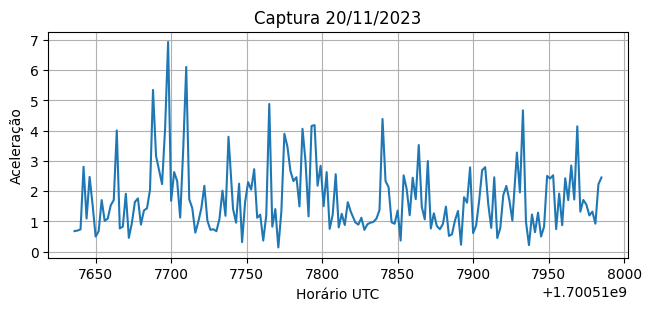

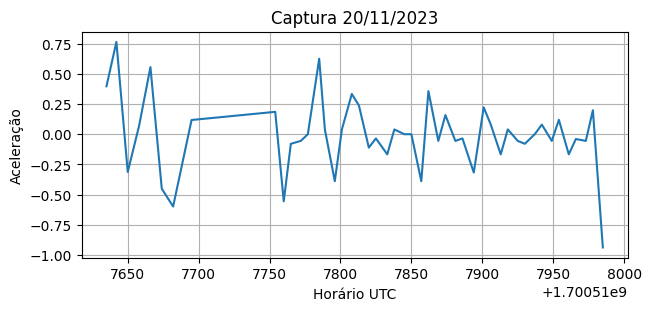

In [41]:
filter_android = (acc_from_android_df["timestamp"] >= min_time_filter) & (acc_from_android_df["timestamp"] <= max_time_filter)
filtered_acc_from_android_df = acc_from_android_df[filter_android].drop_duplicates(subset=["timestamp"])

display_acc_graph(filtered_acc_from_android_df)

filter_obd = (acc_from_obd_df["timestamp"] >= min_time_filter) & (acc_from_obd_df["timestamp"] <= max_time_filter)
filtered_acc_from_obd_df = acc_from_obd_df[filter_obd]

display_acc_graph(filtered_acc_from_obd_df)

1.74597112672711

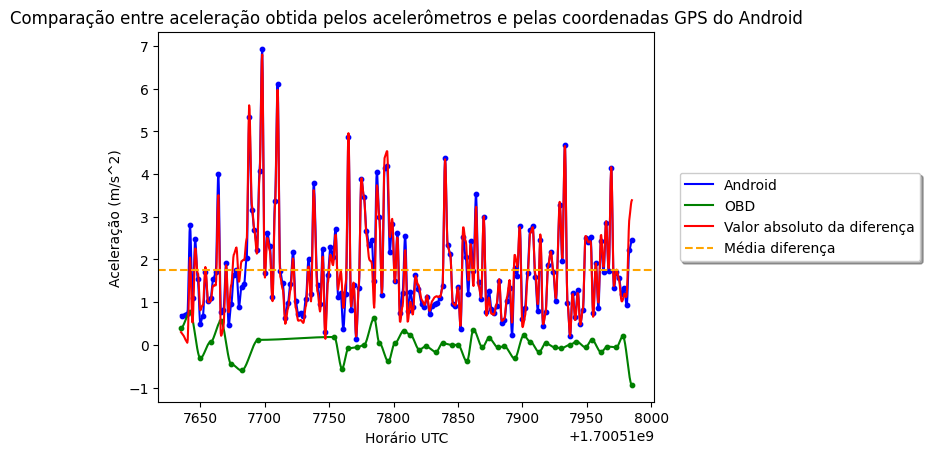

In [42]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# Android
x_android = filtered_acc_from_android_df["timestamp"]
y_android = filtered_acc_from_android_df["acceleration"]
p_android = CubicHermiteSpline(x=x_android, y=y_android, dydx=np.zeros_like(y_android))  # interpolator   
plt.scatter(x_android, y_android, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_android(xx), label="Android")
line.set_color("blue")

# OBD
x_obd = filtered_acc_from_obd_df["timestamp"]
y_obd = filtered_acc_from_obd_df["acceleration"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_android(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Aceleração (m/s^2)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre aceleração obtida pelos acelerômetros e pelas coordenadas GPS do Android")
mean_diff

6.020266833745865

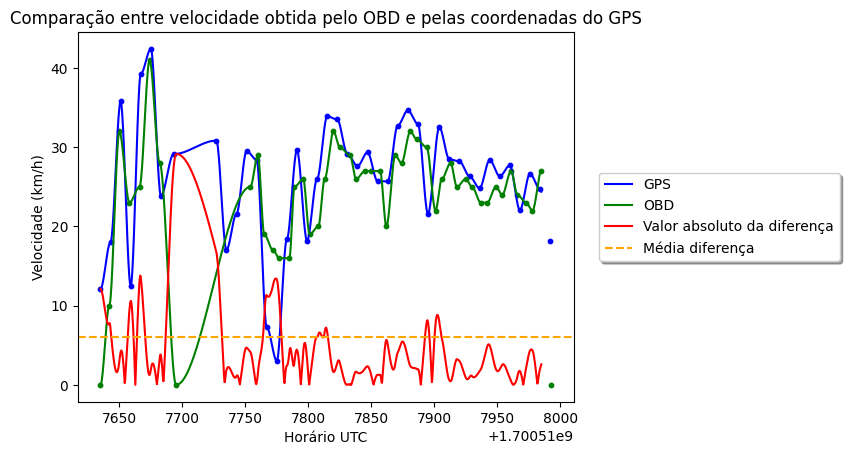

In [43]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# GPS
x_gps = filtered_vels_from_gps_df["timestamp"]
y_gps = filtered_vels_from_gps_df["SPEED"]
p_gps = CubicHermiteSpline(x=x_gps, y=y_gps, dydx=np.zeros_like(y_gps))  # interpolator   
plt.scatter(x_gps, y_gps, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_gps(xx), label="GPS")
line.set_color("blue")

# OBD
x_obd = filtered_vels_from_obd_df["timestamp"]
y_obd = filtered_vels_from_obd_df["SPEED"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_gps(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Velocidade (km/h)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre velocidade obtida pelo OBD e pelas coordenadas do GPS")
mean_diff

In [44]:
start_lat_long = lat_longs[0]
end_lat_long = lat_longs[-1]

mean_lat = latitudes.mean()
mean_long = longitudes.mean()

start_lat_long, end_lat_long, qtty_data

((-23.5524652, -46.6657129), (-23.5524646, -46.6656551), 66)

In [45]:
map = folium.Map(location=[mean_lat, mean_long], zoom_start=14, control_scale=True)

folium.Marker(start_lat_long, popup="start").add_to(map)
folium.Marker(end_lat_long, popup="end").add_to(map)

In [46]:
for i in range(qtty_data - 1):
	location_1 = lat_longs[i]
	location_2 = lat_longs[i + 1]

	folium.PolyLine([location_1, location_2],
					color='red',
					weight=5,
					opacity=0.4).add_to(map)

map

In [47]:
accelerometer_df = real_ride.accelerometer_df
last_timestamp = accelerometer_df.timestamp.iloc[-1] # .timestamp()
delta_time_size = 100 	# 100 s
frame_granularity = 10 	# 50 s
qtty_frames = (last_timestamp - delta_time_size) // frame_granularity

filtered_accelerations_df = accelerometer_df

print("last_timestamp", last_timestamp)
print("qtty_frames", qtty_frames)
print("last_timestamp", last_timestamp)

qtty_frames = min(qtty_frames, 100)

# foo_for_real_data(accelerometer_df, frame_granularity, delta_time_size, 0)

for i in range(10): #qtty_frames):
    real_ride.foo_for_real_data(frame_granularity, delta_time_size, i)


last_timestamp 1700518221.0
qtty_frames 170051812.0
last_timestamp 1700518221.0


Objetivos:
- [] Gerar mapa com a rota feita por cada um dos motoristas
- [] Sincronizar vídeo com eventos de aceleração

In [48]:
# ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151110175712-16km-D1-NORMAL1-SECONDARY")
ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151111125233-24km-D1-AGGRESSIVE-MOTORWAY")

ride = UAHRideParser(ride_root_dir)

# col_names = [str(i) for i in range(13)]
# col_names = ["timestamp", "speed", "lat", "long", "altitude", "vert accuracy", "horiz accuracy", "course", "difcourse", "?1", "?2", "?3", "?4"]
# pd.read_csv(gps_file_path, sep=" ", names=col_names)

ride.gps_df
ride.accelerometer_df

,timestamp,is speed gt 50 kmh,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,roll_degrees,pitch_degrees,yaw_degrees,?1,?2,?3,?4,acc_resultant
0,8.02,1,-0.013,-0.021,0.011,-0.031,-0.009,0.013,-1.627,-0.011,0.294,NaN,NaN,NaN,NaN,0.027037
1,8.12,1,-0.008,-0.005,-0.017,-0.018,-0.011,0.002,-1.626,-0.007,0.297,NaN,NaN,NaN,NaN,0.019442
2,8.22,1,-0.013,-0.026,-0.012,-0.005,-0.011,-0.008,-1.625,-0.003,0.299,NaN,NaN,NaN,NaN,0.031448
3,8.32,1,-0.049,-0.018,0.033,-0.029,-0.018,0.002,-1.626,0.001,0.302,NaN,NaN,NaN,NaN,0.061758
4,8.43,1,0.016,0.009,0.014,-0.021,-0.008,0.021,-1.627,0.004,0.304,NaN,NaN,NaN,NaN,0.023087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,745.45,1,0.004,-0.009,0.019,-0.003,-0.017,0.009,-1.527,0.010,-2.639,NaN,NaN,NaN,NaN,0.021401
7283,745.55,1,-0.013,-0.019,-0.049,0.004,-0.033,-0.005,-1.525,0.015,-2.636,NaN,NaN,NaN,NaN,0.054139
7284,745.65,1,-0.082,-0.012,0.001,-0.043,-0.007,-0.024,-1.526,0.014,-2.637,NaN,NaN,NaN,NaN,0.082879
7285,745.75,1,-0.041,-0.037,0.025,-0.052,-0.021,0.010,-1.528,0.014,-2.632,NaN,NaN,NaN,NaN,0.060622


In [49]:
accelerometer_df = ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 20
frame_granularity = 1
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

for i in range(10): #qtty_frames):
    with ProcessPoolExecutor(max_workers=10) as executor:
        future = executor.submit(ride.foo, accelerometer_df, frame_granularity, delta_time_size, i)

    # print(future.result())

# plt.show()
# RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

qtty_frames 725
oldest_timestamp 745


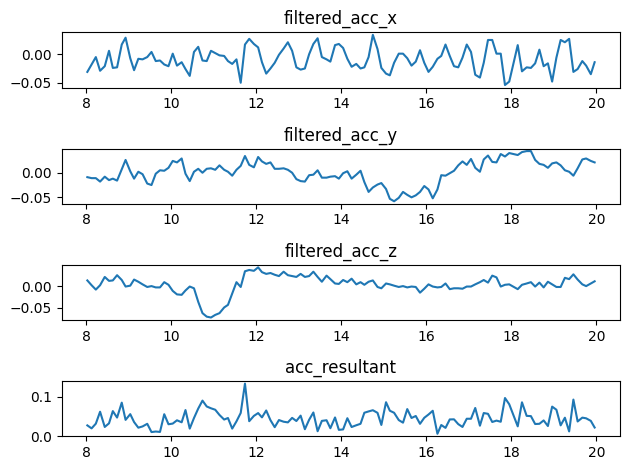

In [50]:
fig, axs = plt.subplots(ncols=1, nrows=4)

accelerometer_df = ride.accelerometer_df
accelerometer_df = accelerometer_df[accelerometer_df.timestamp < 20]
filtered_acc_x = accelerometer_df["filtered_acc_x"]
filtered_acc_y = accelerometer_df["filtered_acc_y"]
filtered_acc_z = accelerometer_df["filtered_acc_z"]
acc_resultant = accelerometer_df["acc_resultant"]
timestamp = accelerometer_df["timestamp"]

# axs[0].scatter(timestamp, filtered_acc_x, s=0.1)
axs[0].plot(timestamp, filtered_acc_x) #, "-o")
axs[0].set_title("filtered_acc_x")

axs[1].plot(timestamp, filtered_acc_y)
axs[1].set_title("filtered_acc_y")

axs[2].plot(timestamp, filtered_acc_z)
axs[2].set_title("filtered_acc_z")

axs[3].plot(timestamp, acc_resultant)
axs[3].set_title("acc_resultant")

fig.tight_layout()

plt.show()

In [51]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

# x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
# y = np.array([[2,2], [3,3], [4,4]])

x = [tuple(el) for _, el in vels_from_obd_df.iterrows()][-107:]
y = [tuple(el) for _, el in vels_from_gps_df.iterrows()][-107:]

distance, path = fastdtw(x, y, dist=euclidean)
print(distance, path)

3205.511156005546 [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (6, 8), (7, 9), (8, 10), (8, 11), (8, 12), (9, 13), (10, 14), (11, 15), (12, 16), (13, 16), (14, 17), (15, 17), (16, 18), (17, 19), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 27), (29, 28), (30, 29), (31, 29), (32, 30), (33, 31), (34, 32), (35, 33), (36, 34), (37, 34), (38, 35), (39, 36), (40, 37), (41, 37), (42, 38), (43, 39), (44, 40), (45, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (47, 47), (47, 48), (47, 49), (47, 50), (47, 51), (47, 52), (47, 53), (47, 54), (47, 55), (47, 56), (47, 57), (47, 58), (47, 59), (47, 60), (47, 61), (47, 62), (47, 63), (47, 64)]


In [52]:
imgs = ride.generate_acc_sub_graph()

# im = Image.open(next(imgs))
# im.show(title="My Image")

In [53]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# import numpy
# from PIL import Image

# n = 20

# img = [] # some array of images
# for i in range(n):
# 	imarray = numpy.random.rand(100,100,3) * 255
# 	im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
# 	img.append(im)

# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(n):
# 	frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, blit=True)

# writergif = animation.PillowWriter(fps=1)
# ani.save('movie.gif', writer=writergif)
# plt.show()

In [54]:
# import io
# from PIL import Image
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# plt.figure()
# plt.plot([1, 2])

# img_buf = io.BytesIO()
# plt.savefig(img_buf, format='png')

# im = Image.open(img_buf)
# im.show(title="My Image")

# img_buf.close()